# Telco Customer Churn Prediction

### Business Context: The Strategic Value of Churn Prediction

In the highly competitive telecommunications sector, the cost of acquiring a new customer is significantly higher than the cost of retaining an existing one. **Customer Churn**—the rate at which customers stop doing business with an entity—directly impacts revenue and market share.

Predicting churn allows companies to:
1.  **Identify At-Risk Customers**: Proactively engage users who show signs of leaving.
2.  **Optimize Marketing Spend**: Allocate retention budgets toward high-value customers with a high probability of churning.
3.  **Improve Service Offerings**: Understand which features (e.g., Fiber optic service or contract types) are linked to higher turnover.

This refined pipeline aims to transform raw behavioral and demographic data into a robust feature set, ensuring high data quality for the benchmarking of advanced machine learning models.

## 1. Import Libraries & Dataset

In [1]:
!pip install kagglehub

In [2]:
import kagglehub
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Download the dataset and check the path
path = kagglehub.dataset_download('blastchar/telco-customer-churn')
print(f'Path to dataset files: {path}')

# Locate the CSV file and load it
csv_filename = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
full_path = os.path.join(path, csv_filename)

if os.path.exists(full_path):
    df = pd.read_csv(full_path)
    print(f'Successfully loaded {csv_filename}')
    print(f'Dataset shape: {df.shape}')
else:
    # Fallback to finding any csv in the directory if name differs
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    if csv_files:
        df = pd.read_csv(os.path.join(path, csv_files[0]))
        print(f'Loaded: {csv_files[0]}')
    else:
        print('No CSV file found in the downloaded path.')

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn
Successfully loaded WA_Fn-UseC_-Telco-Customer-Churn.csv
Dataset shape: (7043, 21)


## 2. Data Inspection

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


#### From the above inspection we could conclude the following

1. The given data is synthesized, as in its proper state
2. We just need to adjust it for our given models

## 3. Preprocessing and Feature Engineering

In [8]:
# Taking a proper copy of the dataset
df_refined = df.copy()

In [9]:
# 2. Convert 'TotalCharges' to numeric, coercing errors to NaN
df_refined['TotalCharges'] = pd.to_numeric(df_refined['TotalCharges'], errors='coerce')

In [10]:
# 3. Fill missing 'TotalCharges' with the median
total_charges_median = df_refined['TotalCharges'].median()
df_refined['TotalCharges'] = df_refined['TotalCharges'].fillna(total_charges_median)

In [11]:
# 4. Drop 'customerID' identifier
df_refined.drop(columns=['customerID'], inplace=True)

In [12]:
# 5. Map 'Churn' target to binary integers
df_refined['Churn'] = df_refined['Churn'].map({'Yes': 1, 'No': 0})

In [13]:
# 6. Identify categorical columns and apply one-hot encoding
# Excluding 'Churn' as it's already encoded
cat_cols = df_refined.select_dtypes(include=['object']).columns.tolist()
df_refined = pd.get_dummies(df_refined, columns=cat_cols, drop_first=True)

In [14]:
print(f'Preprocessing complete.')
print(f'Refined dataset shape: {df_refined.shape}')
print(f'Remaining missing values: {df_refined.isnull().sum().sum()}')
df_refined.head()

Preprocessing complete.
Refined dataset shape: (7043, 31)
Remaining missing values: 0


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


## 4. Data preparation

In [15]:
# Define constants
RANDOM_STATE = 42

# Prepare Features and Target
X = df_refined.drop('Churn', axis=1)
y = df_refined['Churn']

# Train-Test Split. 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [16]:
# 3. Scaling (Required for Linear/Logistic)
scaler_refined = StandardScaler()
X_train_scaled = scaler_refined.fit_transform(X_train)
X_test_scaled = scaler_refined.transform(X_test)

## 5. Train Models

In [17]:
# Linear Regression
linearRegression = LinearRegression()
linearRegression.fit(X_train_scaled, y_train)

LinearRegression()

In [18]:
# Logistic Regression
logisticRegression = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logisticRegression.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [19]:
# Decision Tree
decisionTree = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
decisionTree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [20]:
# Random Forest
randomForest = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
randomForest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# XGBoost
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### 6. Compile Performances & Evaluate

MODEL EVALUATION RESULTS
--------------------------------------------------
Model: LinearRegression
Classification Report
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix
[[926 109]
 [178 196]]


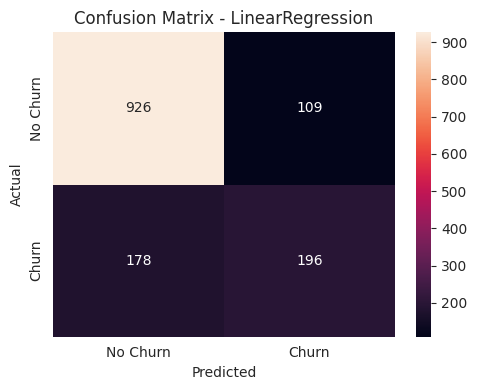

Performance Metrics
Accuracy: 0.7963
Precision: 0.6426
F1-Score: 0.5773
ROC-AUC: 0.8301
--------------------------------------------------
Model: LogisticRegression
Classification Report
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1035
       Churn       0.66      0.57      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix
[[925 110]
 [162 212]]


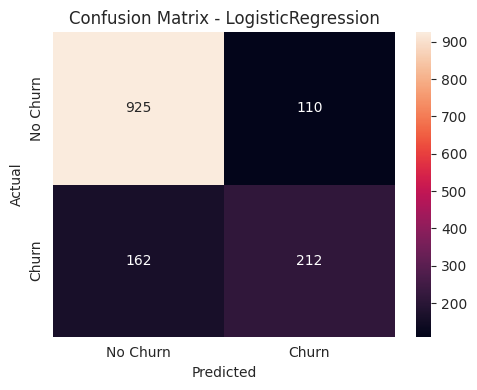

Performance Metrics
Accuracy: 0.807
Precision: 0.6584
F1-Score: 0.6092
ROC-AUC: 0.8416
--------------------------------------------------
Model: DecisionTreeClassifier
Classification Report
              precision    recall  f1-score   support

    No Churn       0.84      0.83      0.83      1035
       Churn       0.54      0.56      0.55       374

    accuracy                           0.76      1409
   macro avg       0.69      0.69      0.69      1409
weighted avg       0.76      0.76      0.76      1409

Confusion Matrix
[[856 179]
 [165 209]]


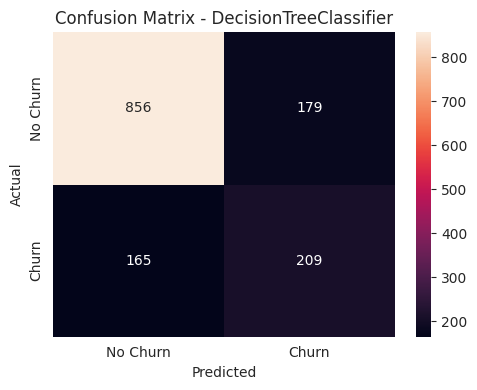

Performance Metrics
Accuracy: 0.7559
Precision: 0.5387
F1-Score: 0.5486
ROC-AUC: 0.7607
--------------------------------------------------
Model: RandomForestClassifier
Classification Report
              precision    recall  f1-score   support

    No Churn       0.83      0.89      0.86      1035
       Churn       0.62      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.77      0.79      0.78      1409

Confusion Matrix
[[924 111]
 [190 184]]


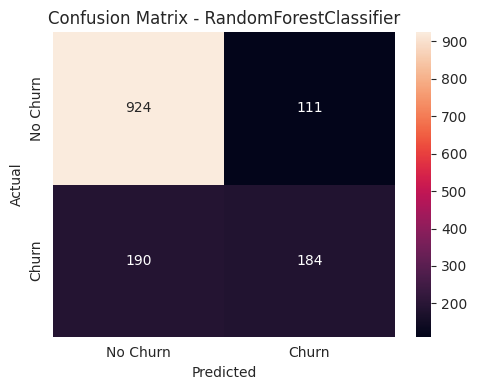

Performance Metrics
Accuracy: 0.7864
Precision: 0.6237
F1-Score: 0.5501
ROC-AUC: 0.8251
--------------------------------------------------
Model: XGBClassifier
Classification Report
              precision    recall  f1-score   support

    No Churn       0.84      0.88      0.86      1035
       Churn       0.61      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

Confusion Matrix
[[906 129]
 [174 200]]


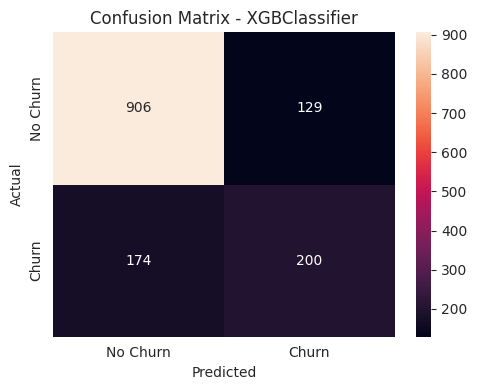

Performance Metrics
Accuracy: 0.785
Precision: 0.6079
F1-Score: 0.569
ROC-AUC: 0.8214
--------------------------------------------------
FINAL MODEL COMPARISON
                 Model  Accuracy  Precision  F1-Score  ROC-AUC
    LogisticRegression  0.806955   0.658385  0.609195 0.841585
      LinearRegression  0.796309   0.642623  0.577320 0.830094
RandomForestClassifier  0.786373   0.623729  0.550075 0.825081
         XGBClassifier  0.784954   0.607903  0.568990 0.821414
DecisionTreeClassifier  0.755855   0.538660  0.548556 0.760726


In [26]:
modelList = [
    (linearRegression,  X_test_scaled),
    (logisticRegression, X_test_scaled),
    (decisionTree,       X_test),
    (randomForest,       X_test),
    (xgboost,            X_test),
]

model_performance = []

print("MODEL EVALUATION RESULTS")

for model, X_eval in modelList:
    name = model.__class__.__name__

    print("--------------------------------------------------")
    print("Model:", name)

    if hasattr(model, 'predict_proba'):
        y_pred = model.predict(X_eval)
        y_prob = model.predict_proba(X_eval)[:, 1]
    else:
        raw_pred = model.predict(X_eval)
        y_pred = (raw_pred >= 0.5).astype(int)
        y_prob = np.clip(raw_pred, 0, 1)

    print("Classification Report")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    print("Confusion Matrix")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title("Confusion Matrix - " + name)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print("Performance Metrics")
    print("Accuracy:", round(acc, 4))
    print("Precision:", round(precision, 4))
    print("F1-Score:", round(f1, 4))
    print("ROC-AUC:", round(roc_auc, 4))

    model_performance.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

print("--------------------------------------------------")
print("FINAL MODEL COMPARISON")

performance_df = pd.DataFrame(model_performance)
print(performance_df.sort_values(by='ROC-AUC', ascending=False).to_string(index=False))

### 7. Visualize the Data

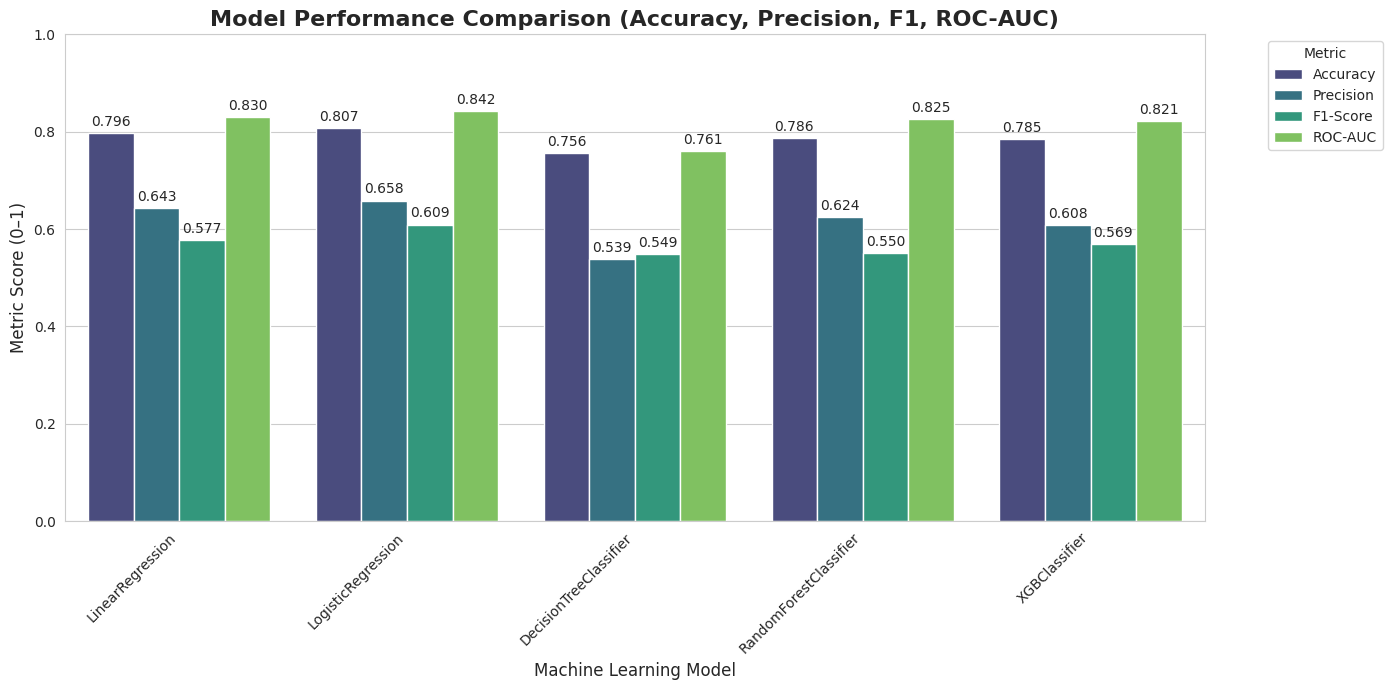

In [27]:
# 1. Melt the performance_df to long format
performance_melted = performance_df.melt(
    id_vars='Model',
    var_name='Metric',
    value_name='Score'
)

# 2. Create grouped bar chart
plt.figure(figsize=(14, 7))
sns.set_style('whitegrid')

ax = sns.barplot(
    data=performance_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette='viridis'
)

# 3. Customize plot
plt.title('Model Performance Comparison (Accuracy, Precision, F1, ROC-AUC)',
          fontsize=16, fontweight='bold')
plt.xlabel('Machine Learning Model', fontsize=12)
plt.ylabel('Metric Score (0–1)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

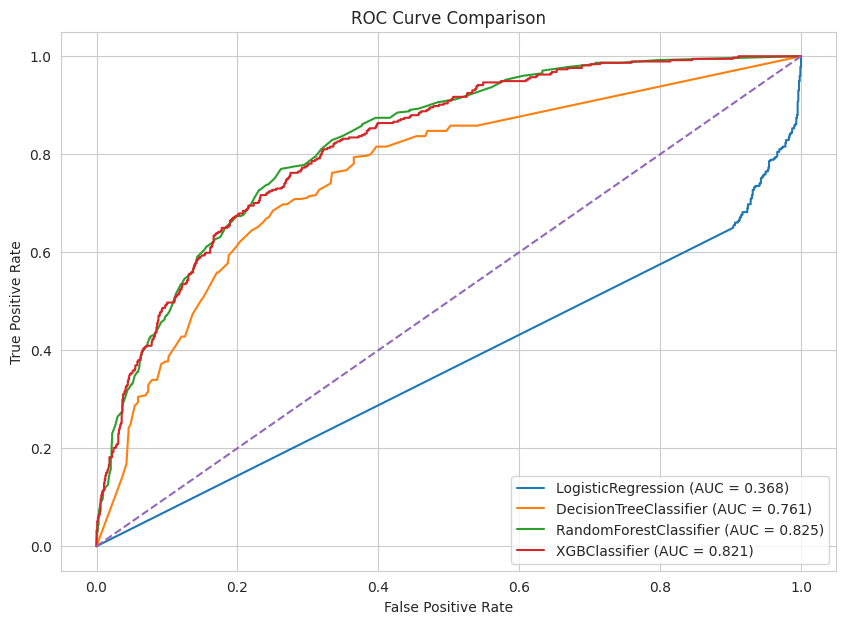

In [28]:
plt.figure(figsize=(10, 7))
probaModels = [logisticRegression, decisionTree, randomForest, xgboost]
for model in probaModels:
    name = model.__class__.__name__

    # Probabilities for positive class
    y_prob = model.predict_proba(X_test)[:, 1]

    # ROC values
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# 8. Find and Export the Best Model

In [ ]:
# 1. Identify the best model name based on F1-Score
best_model_idx = performance_df['F1-Score'].idxmax()
best_model_name = performance_df.loc[best_model_idx, 'Model']
best_f1_score = performance_df.loc[best_model_idx, 'F1-Score']

# 2. Retrieve the model object from the models dictionary
best_model_object = modelList[best_model_idx]

# 3. Create 'models' directory if it doesn't exist
os.makedirs('./models', exist_ok=True)

# 4. Export the model using joblib
model_save_path = './models/model.pkl'
joblib.dump(best_model_object, model_save_path)

# 5. Print confirmation message
print(f'Export Successful!')
print(f'Best Model Identified: {best_model_name}')
print(f'F1-Score: {best_f1_score:.4f}')
print(f'Model saved to: {model_save_path}')

Export Successful!
Best Model Identified: LogisticRegression
F1-Score: 0.6092
Model saved to: ./models/best_churn_model.pkl
